In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Sat Jan 27 01:04:52 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   51C    P0    94W / 300W |   8299MiB / 80994MiB |     25%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = True
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-8_hardquantize/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

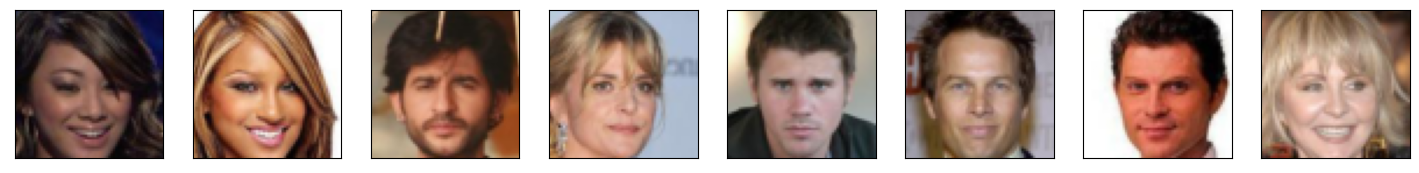

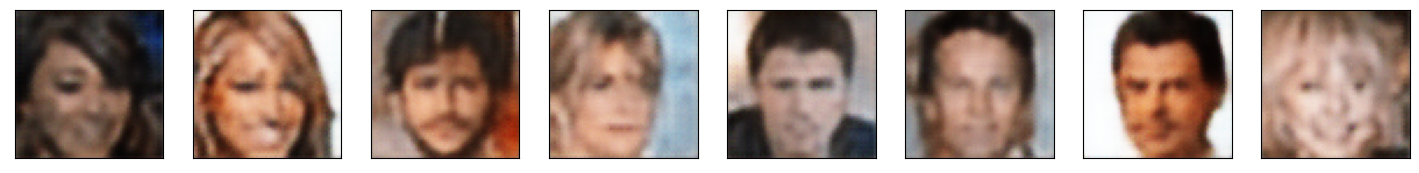

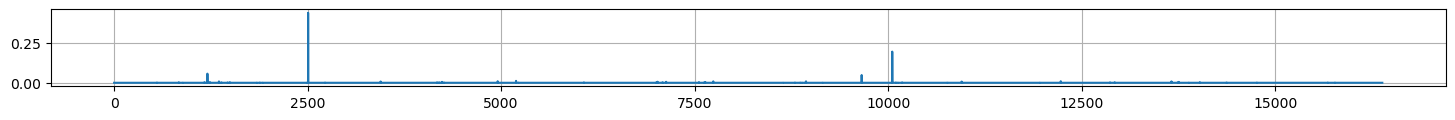

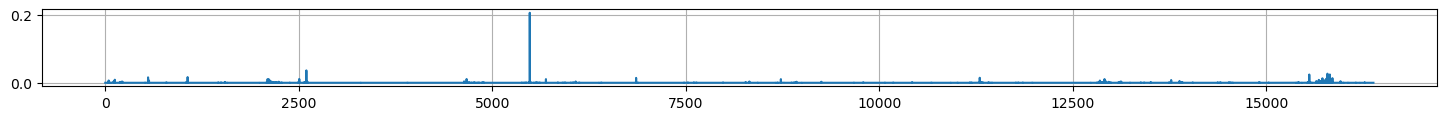

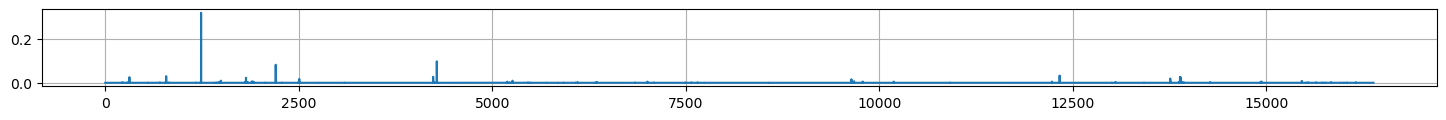

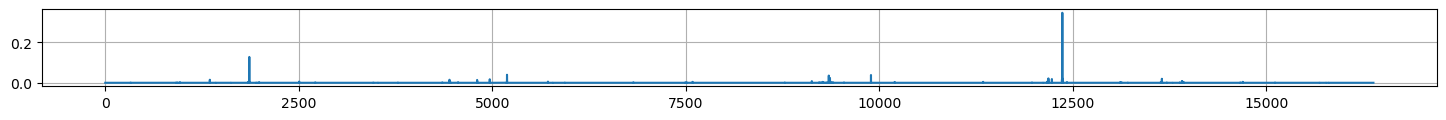

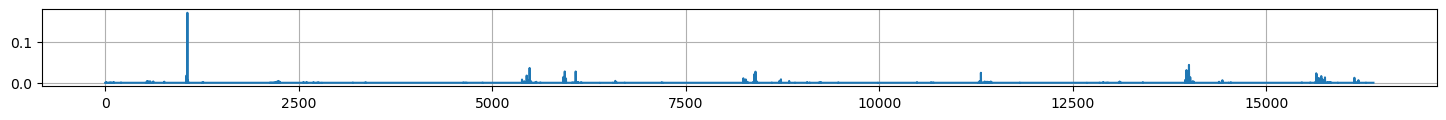

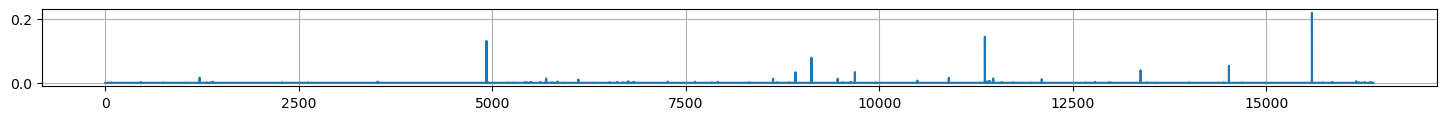

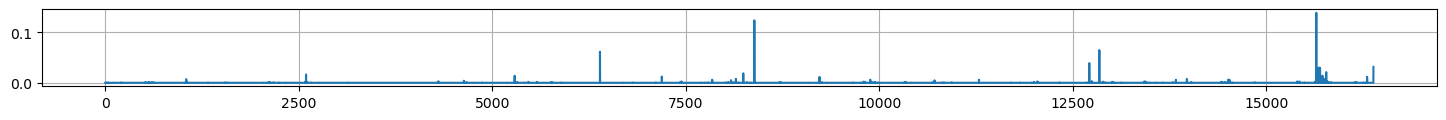

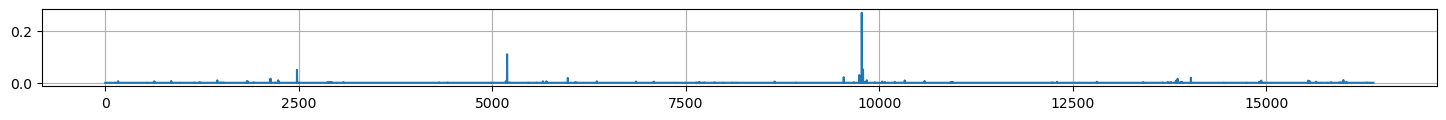

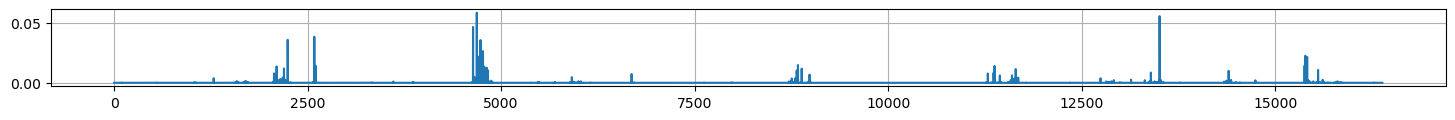

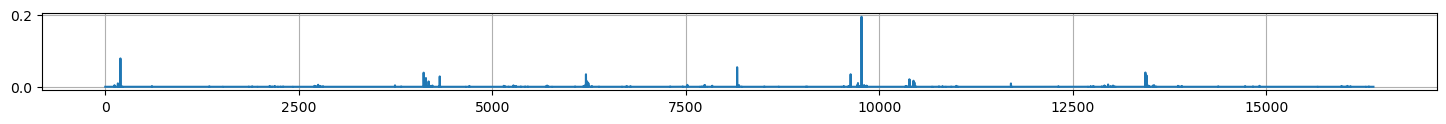

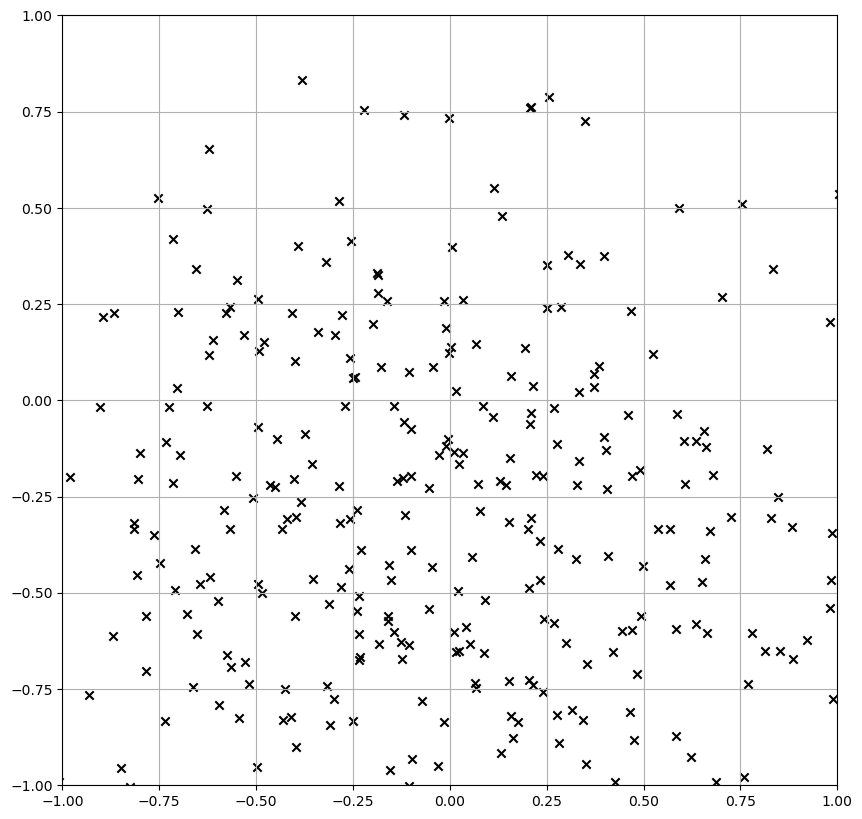

2001
lse_loss -11.849478721618652
commit_loss 0.31676340103149414
recon_loss 0.003982378635555506
2002
lse_loss -11.779623985290527
commit_loss 0.3175593614578247
recon_loss 0.00471911858767271
2003
lse_loss -11.882628440856934
commit_loss 0.3148980438709259
recon_loss 0.004444248043000698
2004
lse_loss -11.768553733825684
commit_loss 0.31451013684272766
recon_loss 0.0044248998165130615
2005
lse_loss -11.744425773620605
commit_loss 0.31490522623062134
recon_loss 0.004150619730353355
2006
lse_loss -11.74973201751709
commit_loss 0.3177100121974945
recon_loss 0.004675086587667465
2007
lse_loss -11.736321449279785
commit_loss 0.31566548347473145
recon_loss 0.004661964252591133
2008
lse_loss -11.835646629333496
commit_loss 0.3147308826446533
recon_loss 0.004231213591992855
2009
lse_loss -11.802681922912598
commit_loss 0.3173021972179413
recon_loss 0.005090184044092894
2010
lse_loss -11.721415519714355
commit_loss 0.3183977007865906
recon_loss 0.0045899394899606705
2011
lse_loss -11.95535755

2087
lse_loss -11.867857933044434
commit_loss 0.3166377544403076
recon_loss 0.004110181238502264
2088
lse_loss -11.955513954162598
commit_loss 0.3161168694496155
recon_loss 0.004338632803410292
2089
lse_loss -12.008265495300293
commit_loss 0.3140910863876343
recon_loss 0.004424735903739929
2090
lse_loss -11.940741539001465
commit_loss 0.31362709403038025
recon_loss 0.003859089221805334
2091
lse_loss -11.875588417053223
commit_loss 0.3164380192756653
recon_loss 0.004137016832828522
2092
lse_loss -11.785529136657715
commit_loss 0.3178715109825134
recon_loss 0.0044453018344938755
2093
lse_loss -11.921050071716309
commit_loss 0.31738799810409546
recon_loss 0.004246534314006567
2094
lse_loss -11.953089714050293
commit_loss 0.316581666469574
recon_loss 0.004601981025189161
2095
lse_loss -11.99030590057373
commit_loss 0.314561665058136
recon_loss 0.004538808949291706
2096
lse_loss -11.847929954528809
commit_loss 0.31946977972984314
recon_loss 0.004775794688612223
2097
lse_loss -11.93425655364

2172
lse_loss -12.068270683288574
commit_loss 0.31592729687690735
recon_loss 0.0040444862097501755
2173
lse_loss -12.04379940032959
commit_loss 0.31431466341018677
recon_loss 0.005383946932852268
2174
lse_loss -12.101840019226074
commit_loss 0.3149595856666565
recon_loss 0.004245180636644363
2175
lse_loss -12.23658275604248
commit_loss 0.3141956329345703
recon_loss 0.004395084921270609
2176
lse_loss -12.12409496307373
commit_loss 0.31473541259765625
recon_loss 0.0043797241523861885
2177
lse_loss -12.054732322692871
commit_loss 0.3150486946105957
recon_loss 0.004403827246278524
2178
lse_loss -12.044722557067871
commit_loss 0.3157963752746582
recon_loss 0.004377191420644522
2179
lse_loss -11.998473167419434
commit_loss 0.316093385219574
recon_loss 0.004456777125597
2180
lse_loss -12.083025932312012
commit_loss 0.3132523000240326
recon_loss 0.005344764795154333
2181
lse_loss -12.132987022399902
commit_loss 0.31327253580093384
recon_loss 0.004318606574088335
2182
lse_loss -11.9976644515991

2259
lse_loss -12.179850578308105
commit_loss 0.3123248219490051
recon_loss 0.0043341247364878654
2260
lse_loss -12.09833812713623
commit_loss 0.3131234645843506
recon_loss 0.004843530245125294
2261
lse_loss -12.082989692687988
commit_loss 0.31694817543029785
recon_loss 0.005873195827007294
2262
lse_loss -12.053494453430176
commit_loss 0.31577545404434204
recon_loss 0.005369079299271107
2263
lse_loss -12.132157325744629
commit_loss 0.31534475088119507
recon_loss 0.004215097054839134
2264
lse_loss -12.025492668151855
commit_loss 0.3143114447593689
recon_loss 0.004169383551925421
2265
lse_loss -12.28620433807373
commit_loss 0.31250685453414917
recon_loss 0.005009591579437256
2266
lse_loss -12.197667121887207
commit_loss 0.31600064039230347
recon_loss 0.004586001392453909
2267
lse_loss -12.176684379577637
commit_loss 0.3173436224460602
recon_loss 0.004438156262040138
2268
lse_loss -12.3475980758667
commit_loss 0.31266772747039795
recon_loss 0.0044470299035310745
2269
lse_loss -12.23005199

lse_loss -12.160271644592285
commit_loss 0.31089186668395996
recon_loss 0.00422319071367383
2346
lse_loss -12.200417518615723
commit_loss 0.3125518560409546
recon_loss 0.004219777882099152
2347
lse_loss -12.168906211853027
commit_loss 0.313946932554245
recon_loss 0.004573003854602575
2348
lse_loss -12.235758781433105
commit_loss 0.31419965624809265
recon_loss 0.004397915210574865
2349
lse_loss -11.997645378112793
commit_loss 0.3160015046596527
recon_loss 0.00438989233225584
2350
lse_loss -12.02784252166748
commit_loss 0.31528520584106445
recon_loss 0.00481624249368906
2351
lse_loss -12.149020195007324
commit_loss 0.31446629762649536
recon_loss 0.0043518999591469765
2352
lse_loss -12.067708015441895
commit_loss 0.31630998849868774
recon_loss 0.0049150120466947556
2353
lse_loss -12.237200736999512
commit_loss 0.31540876626968384
recon_loss 0.004687977023422718
2354
lse_loss -12.410628318786621
commit_loss 0.31205451488494873
recon_loss 0.0054934024810791016
2355
lse_loss -12.310162544250

2431
lse_loss -12.196866035461426
commit_loss 0.31228524446487427
recon_loss 0.004181631375104189
2432
lse_loss -12.039935111999512
commit_loss 0.3109564483165741
recon_loss 0.00399442482739687
2433
lse_loss -12.278077125549316
commit_loss 0.3082810938358307
recon_loss 0.003901058342307806
2434
lse_loss -12.056342124938965
commit_loss 0.31028372049331665
recon_loss 0.004068672191351652
2435
lse_loss -12.179804801940918
commit_loss 0.30972981452941895
recon_loss 0.004510886967182159
2436
lse_loss -12.234213829040527
commit_loss 0.31244364380836487
recon_loss 0.004509957507252693
2437
lse_loss -12.040295600891113
commit_loss 0.3114185333251953
recon_loss 0.0061325803399086
2438
lse_loss -12.160971641540527
commit_loss 0.3116309940814972
recon_loss 0.00413206173107028
2439
lse_loss -12.04188060760498
commit_loss 0.31057170033454895
recon_loss 0.004154318477958441
2440
lse_loss -12.251059532165527
commit_loss 0.31064358353614807
recon_loss 0.0041038403287529945
2441
lse_loss -12.2318716049

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1, quant_temp=0)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-8
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.grid()
plt.show() 